In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa
import numpy as np
import pandas as pd
import os

# Load TinySOL metadata
metadata_path = "TinySOL_metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata.head() # Set the path to the directory containing TinySOL audio files

# Give the path of the audio directory:

audio_dir = r"C:\Users\HP\Desktop\Winter_Project\Code\madhavlabs\TinySOL"


# Function to load and preprocess audio files
def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path)
    # You may need to adjust the audio preprocessing based on your specific requirements
    # For simplicity, let's use the mean and standard deviation of the Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=audio)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.concatenate([mfccs_mean, mfccs_std])

# Load audio data and labels
X = []
y = []

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['Path'])
    features = load_and_preprocess_audio(file_path)
    X.append(features)
    y.append(row['Instrument (in full)'])

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape the data for input to a CNN
X_train = np.array(X_train).reshape(-1, len(X_train[0]), 1)
X_test = np.array(X_test).reshape(-1, len(X_test[0]), 1)

# Define the CNN architecture
model = models.Sequential()
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))






Epoch 1/30


73/73 [==============================] - 1s 6ms/step - loss: 2.1648 - accuracy: 0.6597 - val_loss: 0.3599 - val_accuracy: 0.8765
Epoch 2/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2543 - accuracy: 0.9206 - val_loss: 0.2161 - val_accuracy: 0.9262
Epoch 3/30
73/73 [==============================] - 0s 3ms/step - loss: 0.2045 - accuracy: 0.9339 - val_loss: 0.2175 - val_accuracy: 0.9125
Epoch 4/30
73/73 [==============================] - 0s 3ms/step - loss: 0.1244 - accuracy: 0.9592 - val_loss: 0.1263 - val_accuracy: 0.9640
Epoch 5/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1337 - accuracy: 0.9567 - val_loss: 0.1418 - val_accuracy: 0.9434
Epoch 6/30
73/73 [==============================] - 0s 3ms/step - loss: 0.1121 - accuracy: 0.9588 - val_loss: 0.1077 - val_accuracy: 0.9640
Epoch 7/30
73/73 [==============================] - 0s 3ms/step - loss: 0.0881 - accuracy: 0.9742 - val_loss: 0.1253 - val_accuracy: 0.9605
Epoch 8/30
73/

3) Write a general dataset class, which takes as input the path to the csv file and the folder with the audio files. When called with some input index i, it should return a dictionary with the following items-

In [3]:
# import torch
# from torch.utils.data import Dataset
    
class TinySOLDataset(tf.keras.utils.Sequence):
    def __init__(self, metadata_path, audio_dir, model):
        self.metadata = pd.read_csv('TinySOL_metadata.csv')
        self.audio_dir = audio_dir
        self.model = model
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.metadata['Instrument (in full)'])

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        file_path = os.path.join(self.audio_dir, self.metadata.iloc[index]['Path'])
        audio, _ = librosa.load(file_path)
        features = load_and_preprocess_audio(file_path)

        # Reshape the features for input to the trained CNN model
        features = np.array(features).reshape(-1, len(features), 1)

        # Get the ground truth label
        ground_truth = self.metadata.iloc[index]['Instrument (in full)']

        # Get the predicted label from the trained model
        with tf.device('/CPU:0'):  # Ensure the model is on CPU for inference
            pseudo_label_index = np.argmax(self.model.predict(features), axis=1)[0]
            pseudo_label = self.label_encoder.inverse_transform([pseudo_label_index])[0]

        sample = {
            'file': os.path.basename(file_path),
            'audio': audio,
            'mel': features,
            'gt': ground_truth,
            'pseudo': pseudo_label
        }
        return sample


4. Now train the same CNN from scratch (untrained), but use the ‘psuedo_label’ in the dict output of the dataset as in step-3 as target variable in your loss function.

In [11]:
# Create an instance of the TinySOLDataset
dataset = TinySOLDataset(metadata_path, audio_dir, model)

# Example: Access the first item in the dataset
sample_data = dataset[67]
print(sample_data)
# Assuming X is a list of 2D arrays
X_combined = np.concatenate(X)  # Concatenate along a new axis

# Reshape the combined data to match the expected input shape (sequence_length, num_features)
X_combined = X_combined.reshape(-1, len(X[0]), 1)

# Predict using the combined data
predicted_labels = np.argmax(model.predict(X_combined), axis=1)

# Update the CSV file with predicted labels
metadata['Predicted_Label'] = label_encoder.inverse_transform(predicted_labels)

# Save the updated CSV file
metadata.to_csv("TinySOL_metadata_with_predictions.csv", index=False)# Set the path to the directory containing TinySOL audio files

# Function to load and preprocess audio files
def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path)
    # You may need to adjust the audio preprocessing based on your specific requirements
    # For simplicity, let's use the mean and standard deviation of the Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=audio)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    return np.concatenate([mfccs_mean, mfccs_std])

1/1 [==============================] - 0s 20ms/step
{'file': 'BTb-ord-C#4-mf-N-N.wav', 'audio': array([ 1.3481826e-05,  2.6227906e-05,  9.8535791e-05, ...,
        8.2248152e-07, -2.1692575e-05,  6.2820072e-07], dtype=float32), 'mel': array([[[-636.93933  ],
        [ 119.12589  ],
        [  57.83664  ],
        [   9.262695 ],
        [ -11.882207 ],
        [ -19.047699 ],
        [ -24.669554 ],
        [ -28.765562 ],
        [ -26.214987 ],
        [ -17.593817 ],
        [ -11.312853 ],
        [ -11.905522 ],
        [ -13.426083 ],
        [ -11.45541  ],
        [ -10.348225 ],
        [ -12.581131 ],
        [ -14.020463 ],
        [ -12.654458 ],
        [ -10.776955 ],
        [  -9.258219 ],
        [  19.730608 ],
        [  21.05441  ],
        [   8.731808 ],
        [   5.2906375],
        [   5.3222833],
        [   4.6940746],
        [   4.651592 ],
        [   4.9163623],
        [   4.192469 ],
        [   2.7890666],
        [   2.2269936],
        [   2.564744 

In [5]:
# Load audio data and labels
X = []
y = []

for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['Path'])
    features = load_and_preprocess_audio(file_path)
    X.append(features)
    y.append(row['Predicted_Label'])

# Convert labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Reshape the data for input to a CNN
X_train = np.array(X_train).reshape(-1, len(X_train[0]), 1)
X_test = np.array(X_test).reshape(-1, len(X_test[0]), 1)

# Define the CNN architecture
model = models.Sequential()
model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test)) # Assuming X is a list of 2D arrays
df2 = pd.read_csv("TinySOL_metadata_with_predictions.csv")
X_combined = np.concatenate(X)  # Concatenate along a new axis

# Reshape the combined data to match the expected input shape (sequence_length, num_features)
X_combined = X_combined.reshape(-1, len(X[0]), 1)

# Predict using the combined data
predicted_pseudo_labels = np.argmax(model.predict(X_combined), axis=1)

# Update the CSV file with predicted labels
df2['Predicted_Label1'] = label_encoder.inverse_transform(predicted_pseudo_labels)

# Save the updated CSV file
df2.to_csv("TinySOL_metadata_with_predictions1.csv", index=False)

# df3 = pd.read_csv("TinySOL_metadata_with_predictions1.csv")
# df3.head

Epoch 1/30
73/73 [==============================] - 1s 6ms/step - loss: 1.9842 - accuracy: 0.6446 - val_loss: 0.4661 - val_accuracy: 0.8370
Epoch 2/30
73/73 [==============================] - 0s 4ms/step - loss: 0.3340 - accuracy: 0.8948 - val_loss: 0.5633 - val_accuracy: 0.8148
Epoch 3/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2484 - accuracy: 0.9240 - val_loss: 0.2652 - val_accuracy: 0.9091
Epoch 4/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1453 - accuracy: 0.9545 - val_loss: 0.1954 - val_accuracy: 0.9451
Epoch 5/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1643 - accuracy: 0.9545 - val_loss: 0.2409 - val_accuracy: 0.9365
Epoch 6/30
73/73 [==============================] - 0s 4ms/step - loss: 0.2253 - accuracy: 0.9330 - val_loss: 0.2194 - val_accuracy: 0.9314
Epoch 7/30
73/73 [==============================] - 0s 4ms/step - loss: 0.1424 - accuracy: 0.9519 - val_loss: 0.2015 - val_accuracy: 0.9383
Epoch 8/30
73/73 [==

5. Now analyze the results (accuracy, loss) and plot some graphs to contrast in the CNN’s performance when trained using the correct ground truth labels (step-2) with the case when trained using the pseudo labels.

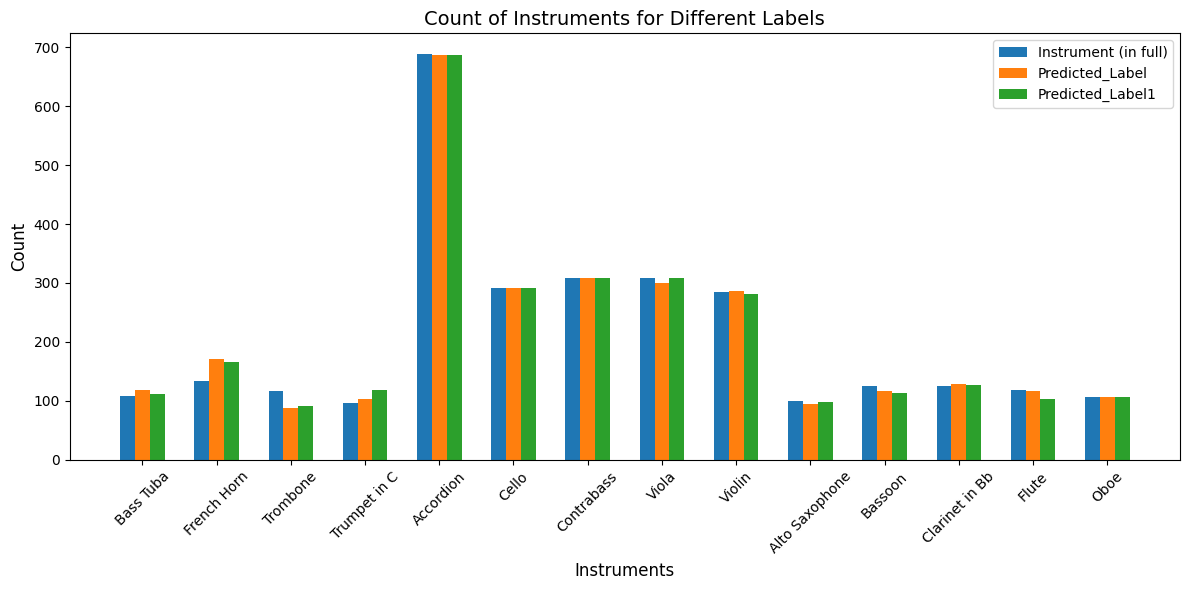

In [10]:
# Now analyze the results (accuracy, loss) and plot some graphs to contrast in the CNN’s performance when trained using the correct ground truth labels (step-2) with the case when trained using the pseudo labels.

import pandas as pd
import matplotlib.pyplot as plt

# file_path is the path of the new csv file formed with the name TinySOL_metadata_with_predictions1.csv
file_path = "TinySOL_metadata_with_predictions1.csv"
metadata = pd.read_csv(file_path)

# Get unique instruments
instruments = metadata['Instrument (in full)'].unique()

# Count occurrences for each instrument in the three label columns
count_in_full = metadata['Instrument (in full)'].value_counts()
count_predicted_label = metadata['Predicted_Label'].value_counts()
count_predicted_label1 = metadata['Predicted_Label1'].value_counts()

# Plotting the bar graph
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = range(len(instruments))

# Bar for 'Instrument (in full)'
ax.bar(index, count_in_full[instruments], width=bar_width, label='Instrument (in full)')

# Bar for 'Predicted_Label'
ax.bar([i + bar_width for i in index], count_predicted_label[instruments], width=bar_width, label='Predicted_Label')

# Bar for 'Predicted_Label1'
ax.bar([i + 2 * bar_width for i in index], count_predicted_label1[instruments], width=bar_width, label='Predicted_Label1')

# Set labels and title
ax.set_xlabel('Instruments', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Count of Instruments for Different Labels', fontsize=14)
ax.set_xticks([i + bar_width for i in index])
ax.set_xticklabels(instruments, fontsize=10, rotation=45)  # Adjust font size and rotation
ax.legend()

# Show the plot
plt.tight_layout()  # Adjust layout for better appearance
plt.show()
